## Initial ML investigations
This is the very first investigations we did into how ML could help us predict Z_diff. This does *not* use the ErrorML library, as it predates that. Basically just some investigations of various types of regression.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoLarsCV
from sklearn import ensemble
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score

In [4]:
# From https://medium.com/dunder-data/from-pandas-to-scikit-learn-a-new-exciting-workflow-e88e2271ef62
from sklearn.base import BaseEstimator
class BasicTransformer(BaseEstimator):
    
    def __init__(self, cat_threshold=None, num_strategy='median',
                 return_df=False):
        # store parameters as public attributes
        self.cat_threshold = cat_threshold
        
        if num_strategy not in ['mean', 'median']:
            raise ValueError('num_strategy must be either "mean" or '
                             '"median"')
        self.num_strategy = num_strategy
        self.return_df = return_df
        
    def fit(self, X, y=None):
        # Assumes X is a DataFrame
        self._columns = X.columns.values
        
        # Split data into categorical and numeric
        self._dtypes = X.dtypes.values
        self._kinds = np.array([dt.kind for dt in X.dtypes])
        self._column_dtypes = {}
        is_cat = self._kinds == 'O'
        self._column_dtypes['cat'] = self._columns[is_cat]
        self._column_dtypes['num'] = self._columns[~is_cat]
        self._feature_names = self._column_dtypes['num']
        
        # Create a dictionary mapping categorical column to unique 
        # values above threshold
        self._cat_cols = {}
        for col in self._column_dtypes['cat']:
            vc = X[col].value_counts()
            if self.cat_threshold is not None:
                vc = vc[vc > self.cat_threshold]
            vals = vc.index.values
            self._cat_cols[col] = vals
            self._feature_names = np.append(self._feature_names, col 
                                            + '_' + vals)
            
        # get total number of new categorical columns    
        self._total_cat_cols = sum([len(v) for col, v in 
                                    self._cat_cols.items()])
        
        # get mean or median
        num_cols = self._column_dtypes['num']
        self._num_fill = X[num_cols].agg(self.num_strategy)
        return self
        
    def transform(self, X):
        # check that we have a DataFrame with same column names as 
        # the one we fit
        if set(self._columns) != set(X.columns):
            raise ValueError('Passed DataFrame has different columns '
                              'than fit DataFrame')
        elif len(self._columns) != len(X.columns):
            raise ValueError('Passed DataFrame has different number '
                              'of columns than fit DataFrame')
            
        # fill missing values
        num_cols = self._column_dtypes['num']
        X_num = X[num_cols].fillna(self._num_fill)
        
        # Standardize numerics
        std = X_num.std()
        X_num = (X_num - X_num.mean()) / std
        zero_std = np.where(std == 0)[0]
        
        # If there is 0 standard deviation, then all values are the 
        # same. Set them to 0.
        if len(zero_std) > 0:
            X_num.iloc[:, zero_std] = 0
        X_num = X_num.values
        
        # create separate array for new encoded categoricals
        X_cat = np.empty((len(X), self._total_cat_cols), 
                         dtype='int')
        i = 0
        for col in self._column_dtypes['cat']:
            vals = self._cat_cols[col]
            for val in vals:
                X_cat[:, i] = X[col] == val
                i += 1
                
        # concatenate transformed numeric and categorical arrays
        data = np.column_stack((X_num, X_cat))
        
        # return either a DataFrame or an array
        if self.return_df:
            return pd.DataFrame(data=data, 
                                columns=self._feature_names)
        else:
            return data
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)
    
    def get_feature_names():
        return self._feature_names

In [26]:
df = pd.read_csv('2016_ValidationPts_ALL_Python.csv', na_values='-9999.0')

In [27]:
len(df)

1522

In [28]:
df.columns

Index(['Z_diff', 'Z_diff_foc', 'Slope', 'MaxSl_Foc', 'Rough40cm', 'Rough40Foc',
       'CQ_Mean', 'CQmean_Foc', 'VEG_TREES', 'DoD', 'Pt_Density',
       'DepthRC_JD'],
      dtype='object')

In [29]:
df = df[['Z_diff', 'Slope', 'MaxSl_Foc', 'Rough40cm', 'Rough40Foc',
       'CQ_Mean', 'CQmean_Foc', 'VEG_TREES', 'Pt_Density',
       'DepthRC_JD']]

In [30]:
df = df.sample(frac=1)

In [31]:
y = df.pop('Z_diff').values

y_train = y[:1200]
y_test = y[1200:]

X = df

X_train = X.iloc[:1200]
X_test = X.iloc[1200:]

In [32]:
bt = BasicTransformer(cat_threshold=3, return_df=True)

In [33]:
def run_cross_val(pipeline):
    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    abs_error = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error').mean()*-1
    print('Absolute error: %f' % abs_error)
    r2 = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='r2').mean()
    print('R2: %f' % r2)

# Z_diff statistics (for comparison)

In [34]:
pd.Series(y).describe()

count    1522.000000
mean        0.026402
std         0.243286
min        -1.710000
25%        -0.008000
50%         0.040000
75%         0.094000
max         4.482000
dtype: float64

In [35]:
pd.Series(y).abs().describe()

count    1522.000000
mean        0.116121
std         0.215389
min         0.000000
25%         0.028000
50%         0.059000
75%         0.118000
max         4.482000
dtype: float64

# Linear Regression (using all variables)

In [36]:
lr_pipe = Pipeline([('bt', bt), ('lr', LinearRegression())])
run_cross_val(lr_pipe)

Absolute error: 0.120053
R2: 0.066271


In [37]:
lr_pipe.fit(X_train, y_train)

coef = lr_pipe.named_steps.lr.coef_
X_transformed = bt.transform(X)

lr_importances = pd.Series(coef, index=X_transformed.columns).sort_values(ascending=False)
lr_importances.head(10)

VEG_TREES_Veg&Trees    0.328790
Rough40Foc             0.055447
DepthRC_JD             0.013462
CQ_Mean                0.001160
Slope                  0.000905
VEG_TREES_Tall Veg    -0.004499
CQmean_Foc            -0.007879
Rough40cm             -0.015769
Pt_Density            -0.025493
MaxSl_Foc             -0.097636
dtype: float64

In [38]:
# How many parameters overall?
len(X_transformed.columns)

11

In [39]:
y_test_pred = lr_pipe.predict(X_test)
mae = mean_absolute_error(y_test_pred, y_test)
print('MAE on test set: %f' % mae)

MAE on test set: 0.098666


# Ridge Regression

In [40]:
ridge_pipe = Pipeline([('bt', bt), ('ridge', RidgeCV())])
run_cross_val(ridge_pipe)

Absolute error: 0.117940
R2: 0.105656


In [41]:
ridge_pipe.fit(X_train, y_train)
coef = ridge_pipe.named_steps.ridge.coef_

X_transformed = bt.transform(X_train)

ridge_importances = pd.Series(coef, index=X_transformed.columns).sort_values(ascending=False)
ridge_importances.head(10)

VEG_TREES_Veg&Trees    0.197594
Rough40Foc             0.054874
VEG_TREES_Tall Veg     0.051260
DepthRC_JD             0.012626
Slope                  0.000837
CQmean_Foc             0.000790
CQ_Mean               -0.006796
Rough40cm             -0.017225
Pt_Density            -0.026036
MaxSl_Foc             -0.092447
dtype: float64

# Random Forests

In [46]:
rf_pipe = Pipeline([('bt', bt), ('rf', RandomForestRegressor(n_estimators=500))])
run_cross_val(rf_pipe)

Absolute error: 0.103703
R2: 0.217898


In [23]:
rf_pipe.fit(X_train, y_train)
imps = rf_pipe.named_steps.rf.feature_importances_ / rf_pipe.named_steps.rf.feature_importances_.max()

X_transformed = bt.transform(X)
rf_importances = pd.Series(imps, index=X_transformed.columns).sort_values(ascending=False)
rf_importances.head(10)
# list(X_transformed.columns[np.argsort(imps)[::-1]])[:10]

MaxSl_Foc              1.000000
VEG_TREES_Veg&Trees    0.445008
Slope                  0.336401
Pt_Density             0.318932
Rough40cm              0.287213
CQ_Mean                0.267676
Rough40Foc             0.246196
CQmean_Foc             0.185877
VEG_TREES_N/a          0.117101
VEG_TREES_Tall Veg     0.042342
dtype: float64

# LassoLarsCV

In [24]:
ll_pipe = Pipeline([('bt', bt), ('ll', LassoLarsCV(normalize=False))])
run_cross_val(ll_pipe)

Absolute error: 0.109366
R2: 0.196412


In [23]:
ll_pipe.fit(X_train, y_train)

coef = ll_pipe.named_steps.ll.coef_

X_transformed = bt.transform(X_train)

ridge_importances = pd.Series(coef, index=X_transformed.columns).sort_values(ascending=False)
ridge_importances.head(10)

DepthRC_JD             0.017322
CQ_Min                 0.004342
VEG_TREES_Veg&Trees    0.000000
VEG_TREES_Tall Veg     0.000000
Type_Submerged         0.000000
Type_Exposed           0.000000
Rough40cm              0.000000
Slope                  0.000000
CQ_Mean               -0.005353
Pt_Density            -0.015824
dtype: float64

# Gradient Boosted Regression

In [24]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
gbr = ensemble.GradientBoostingRegressor(**params)
gbr_pipe = Pipeline([('bt', bt), ('gbr', gbr)])

In [25]:
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=5, shuffle=True, random_state=1234)
abs_error = cross_val_score(gbr_pipe, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error').mean()*-1
print('Absolute error: %f' % abs_error)
r2 = cross_val_score(gbr_pipe, X_train, y_train, cv=kf, scoring='r2').mean()
print('R2: %f' % r2)

Absolute error: 0.105124
R2: -0.316943


In [140]:
gbr_pipe.fit(X_train, y_train)
imps = gbr_pipe.named_steps.gbr.feature_importances_ / gbr_pipe.named_steps.gbr.feature_importances_.max()

X_transformed = bt.transform(X)
gbr_importances = pd.Series(imps, index=X_transformed.columns).sort_values(ascending=False)
gbr_importances.head(10)
# list(X_transformed.columns[np.argsort(imps)[::-1]])[:10]

MaxSl_Foc     1.000000
Z_RCDEM_JD    0.752454
Slope         0.266270
Rough10cm     0.246619
Rough50cm     0.213466
Pt_Density    0.206300
Rough30cm     0.167539
Rough20cm     0.156715
Rough40cm     0.107154
DepthRC_JD    0.084141
dtype: float64

# Anomaly detection

In [141]:
isolf = ensemble.IsolationForest(max_samples=100,
                                 contamination=0.05)
ifpipe = Pipeline([('bt', bt), ('isolf', isolf)])

In [142]:
ifpipe.fit(X)
pred = ifpipe.predict(X)

In [143]:
len(pred[pred==-1])

77

In [144]:
df['Outlier'] = pred==-1

In [145]:
import seaborn as sns

In [147]:
df['Z_diff'] = y

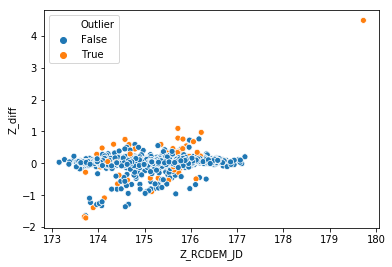

In [148]:
sns.scatterplot(x='Z_RCDEM_JD', y='Z_diff', hue='Outlier', data=df)

# TPOT

In [26]:
bt = BasicTransformer(cat_threshold=3, return_df=True)

In [30]:
subdf = pd.read_csv('2016_ValidationPoints_ALL_AppendedData2_Robin.csv', na_values='-9999.0')

In [31]:
tpot_y = subdf.pop('Z_diff').values
tpot_y_train = tpot_y[:1200]
tpot_y_test = tpot_y[1200:]

In [32]:
transformed_df = bt.fit_transform(subdf)

In [33]:


tpot_X = transformed_df.astype(float)

tpot_X_train = tpot_X.iloc[:1200]
tpot_X_test = tpot_X.iloc[1200:]

In [34]:
from tpot import TPOTRegressor

In [35]:
tpot = TPOTRegressor(verbosity=2, population_size=100, scoring='neg_mean_absolute_error')

In [36]:
tpot.fit(tpot_X_train, tpot_y_train)

HBox(children=(IntProgress(value=0, description='Optimization Progress', max=10100), HTML(value='')))

Generation 1 - Current best internal CV score: -0.08676159480111559


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestRegressor(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), bootstrap=False, max_features=0.25, min_samples_leaf=18, min_samples_split=12, n_estimators=100)


TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=5,
       disable_update_check=False, early_stop=None, generations=100,
       max_eval_time_mins=5, max_time_mins=None, memory=None,
       mutation_rate=0.9, n_jobs=1, offspring_size=None,
       periodic_checkpoint_folder=None, population_size=100,
       random_state=None, scoring='neg_mean_absolute_error', subsample=1.0,
       use_dask=False, verbosity=2, warm_start=False)

In [93]:
tpot.score(tpot_X_test, tpot_y_test)

-0.020144319690117565

In [102]:
pred = tpot.predict(tpot_X_test)

In [103]:
mean_absolute_error(pred, tpot_y_test)

0.08934534474682052

In [94]:
tpot.export('tpot_2min_test_1.py')

True

In [95]:
# LassoLarsCV(PolynomialFeatures(LinearSVR(input_matrix, C=15.0, dual=True, epsilon=0.1, loss=squared_epsilon_insensitive, tol=0.01), degree=2, include_bias=False, interaction_only=False), normalize=False)

In [96]:
!cat tpot_2min_test_1.py

import numpy as np
import pandas as pd
from sklearn.linear_model import LassoLarsCV, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MaxAbsScaler, PolynomialFeatures
from tpot.builtins import StackingEstimator

# NOTE: Make sure that the class is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1).values
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'].values, random_state=None)

# Average CV score on the training set was:-0.025640623302305182
exported_pipeline = make_pipeline(
    MaxAbsScaler(),
    StackingEstimator(estimator=RidgeCV()),
    StackingEstimator(estimator=RidgeCV()),
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
    LassoLarsCV(normalize=False)


# TPOT LassoLarsCV

In [149]:
ll = LassoLarsCV(normalize=False)

In [150]:
ll.fit(tpot_X_train, tpot_y_train)

/Users/robin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=4.852e-04, previous alpha=4.852e-04, with an active set of 25 regressors.
  ConvergenceWarning)


LassoLarsCV(copy_X=True, cv=None, eps=2.220446049250313e-16,
      fit_intercept=True, max_iter=500, max_n_alphas=1000, n_jobs=1,
      normalize=False, positive=False, precompute='auto', verbose=False)

In [151]:
results = ll.predict(tpot_X_test)

In [152]:
results[:10]

array([ 0.04663139, -0.32966983,  0.05098763,  0.03650263,  0.08366404,
        0.20051032,  0.03451342,  0.13963269,  0.05157179,  0.18154771])

In [153]:
tpot_y_test[:10]

array([ 0.094, -0.887,  0.03 ,  0.17 , -0.067,  0.115, -0.009,  0.054,
       -0.001,  0.049])

In [154]:
mean_absolute_error(tpot_y_test, results)

0.11758316224510458

In [155]:
r2_score(tpot_y_test, results)

0.2292388130676558

In [156]:
ll.coef_

array([ 0.01382866, -0.08008003,  0.02873622,  0.10959027, -0.01892801,
        0.00176155,  0.00300947,  0.04662548,  0.00052945, -0.03213642,
        0.00914337,  0.        ,  0.05613255,  0.07079346,  0.0910695 ,
       -0.0341951 , -0.11492109,  0.00570073,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.09538935, -0.27939869,  0.        ,  0.19393112])

In [157]:
ll_importances = pd.Series(ll.coef_, index=tpot_X_train.columns)
ll_importances[ll_importances.abs() > 0]

Slope                  0.013829
MaxSl_Foc             -0.080080
DepthRC_JD             0.028736
Z_RCDEM_JD             0.109590
Pt_Density            -0.018928
Rough10cm              0.001762
Rough20cm              0.003009
Rough30cm              0.046625
Rough40cm              0.000529
Rough50cm             -0.032136
Outlier                0.009143
BlockCode_BREAKS2      0.056133
BlockCode_BREAKS       0.070793
BlockCode_WATER        0.091069
BlockCode_LINE6       -0.034195
BlockCode_LINE2       -0.114921
BlockCode_LINE7        0.005701
Type_Submerged         0.095389
VEG_TREES_N/a         -0.279399
VEG_TREES_Veg&Trees    0.193931
dtype: float64

In [54]:
ll.intercept_

0.3769693855491752

In [55]:
ll._decision_function??

In [56]:
cols = list(ll_importances[ll_importances.abs() > 0].index)

In [57]:
cols

['Slope',
 'MaxSl_Foc',
 'DepthRC_JD',
 'Z_RCDEM_JD',
 'Pt_Density',
 'Rough10cm',
 'Rough20cm',
 'Rough30cm',
 'Rough50cm',
 'Type_Exposed',
 'VEG_TREES_N/a',
 'VEG_TREES_Veg&Trees']

In [58]:
test_df = tpot_X_test[cols].head()

In [59]:
test_df

,Slope,MaxSl_Foc,DepthRC_JD,Z_RCDEM_JD,Pt_Density,Rough10cm,Rough20cm,Rough30cm,Rough50cm,Type_Exposed,VEG_TREES_N/a,VEG_TREES_Veg&Trees
1200,-0.715860,-0.859958,-0.095595,-0.409237,0.188476,-0.206930,0.129445,0.470788,0.645426,1.0,1.0,0.0
1201,1.087976,2.494035,-0.095595,-0.175639,0.771921,0.247213,0.604601,1.705778,1.323484,1.0,1.0,0.0
1202,-0.669447,-0.983693,-0.095595,-0.112162,-0.394969,-0.950073,-0.890401,-0.972513,-0.511949,1.0,1.0,0.0
1203,-0.477423,-0.464300,-0.095595,-0.206109,0.966402,1.630284,0.477120,0.002087,-0.246961,1.0,1.0,0.0
1204,-0.525870,-0.504675,-0.095595,-1.381714,-0.783932,2.373427,1.299951,0.537745,-0.114467,0.0,1.0,0.0


In [60]:
pred_y = (ll.intercept_ + (-0.7747 * tpot_X_test.Z_BNG) +
                                 (0.7876 * tpot_X_test.Z_RCDEM_JD))
                                 #(-3.330669e-16 * tpot_X_test.MaxSl_Foc) +
                                 #(-9.506285e-16 * tpot_X_test.DoD) + 
                                 #(-4.614364e-16 * tpot_X_test.Pt_Density))

AttributeError: 'DataFrame' object has no attribute 'Z_BNG'

In [ ]:
ll.coef_

In [ ]:
(0.5 * 2) + (-0.45 * 5)

In [ ]:
(0.5 - 0.45) * (2 + 5)

In [ ]:
def dot_product(matrix, vector):
    result = 0
    for index, value in enumerate(vector):
        result += (value * matrix.iloc[:,index])
        
    return result

In [ ]:
dot_product(tpot_X_test, ll.coef_) + ll.intercept_

In [ ]:
ll.coef_.T

In [ ]:
results = pd.DataFrame({'pred': pred_y, 'actual': tpot_y_test, 'err':pred_y-tpot_y_test})

In [ ]:
results.head()

In [ ]:
results.err.abs().describe()

# TPOT LassoLars with PolynomialFeatures

In [98]:
pipeline = make_pipeline(
#     MaxAbsScaler(),
#     StackingEstimator(estimator=RidgeCV()),
#     StackingEstimator(estimator=RidgeCV()),
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
    LassoLarsCV(normalize=False)
)

In [99]:
pipeline.fit(tpot_X_train, tpot_y_train)
results = pipeline.predict(tpot_X_test)

/Users/robin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 205 iterations, i.e. alpha=2.984e-04, with an active set of 137 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/robin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 215 iterations, i.e. alpha=2.774e-04, with an active set of 141 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/robin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 244 iterations, alp

In [100]:
pipeline.score(tpot_X_test, tpot_y_test)

0.4718642925080869

In [101]:
mean_absolute_error(results, tpot_y_test)

0.09261113619622544